In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# 用卷积神经网络处理序列

This notebook contains the code samples found in Chapter 6, Section 4 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.




## 理解序列数据的一维卷积

Keras 中的一维卷积神经网络是 Conv1D 层，其接口类似于 Conv2D。它接收的输入是形状
为 (samples, time, features) 的三维张量，并返回类似形状的三维张量。卷积窗口是时
间轴上的一维窗口（时间轴是输入张量的第二个轴）。

我们来构建一个简单的两层一维卷积神经网络，并将其应用于我们熟悉的 IMDB 情感分类
任务。提醒一下，获取数据并预处理的代码如下所示。

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
max_len = 500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
17465344/17464789 [==============================] - 3s 0us/step
25000 train sequences
25000 test sequences


In [0]:
x_train[0]

In [4]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


一维卷积神经网络的架构与第 5 章的二维卷积神经网络相同，它是 Conv1D 层和 MaxPooling1D
层的堆叠，最后是一个全局池化层或 Flatten 层，将三维输出转换为二维输出，让你可以向模
型中添加一个或多个 Dense 层，用于分类或回归。

不过二者有一点不同：一维卷积神经网络可以使用更大的卷积窗口。对于二维卷积层，
3×3 的卷积窗口包含 3×3=9 个特征向量；但对于一位卷积层，大小为 3 的卷积窗口只包含 3
个卷积向量。因此，你可以轻松使用大小等于 7 或 9 的一维卷积窗口。

用于 IMDB 数据集的一维卷积神经网络示例如下所示。

In [5]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()
# 494=500-7+1
# 7*128+1=897*32=28704

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable para

In [6]:
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 8s 393us/step - loss: 0.8337 - acc: 0.5092 - val_loss: 0.6874 - val_acc: 0.5640
Epoch 2/10
20000/20000 [==============================] - 3s 149us/step - loss: 0.6699 - acc: 0.6389 - val_loss: 0.6642 - val_acc: 0.6558
Epoch 3/10
20000/20000 [==============================] - 3s 149us/step - loss: 0.6235 - acc: 0.7527 - val_loss: 0.6083 - val_acc: 0.7436
Epoch 4/10
20000/20000 [==============================] - 3s 149us/step - loss: 0.5259 - acc: 0.8077 - val_loss: 0.4847 - val_acc: 0.8066
Epoch 5/10
20000/20000 [==============================] - 3s 148us/step - loss: 0.4120 - acc: 0.8483 - val_loss: 0.4255 - val_acc: 0.8338
Epoch 6/10
20000/20000 [==============================] - 3s 149us/step - loss: 0.3504 - acc: 0.8683 - val_loss: 0.4150 - val_acc: 0.83

这里给出了模型的训练结果和验证结果。验证精度略低于 LSTM，但在 CPU 和 GPU 上的运行速度都要更快（速度提高多少取决于具体配置，会有很大差异）。现在，你可以使用正确的轮数（10 轮）重新训练这个模型，然后在测试集上运行。这个结果可以让我们确信，在单词级的情感分类任务上，一维卷积神经网络可以替代循环网络，并且速度更快、计算代价更低。

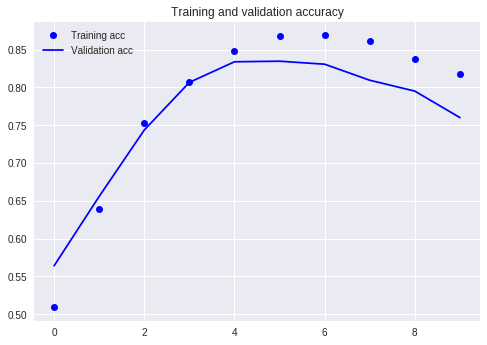

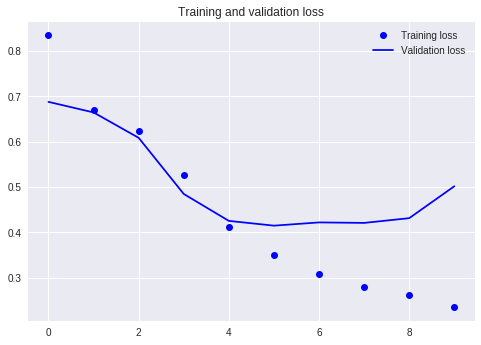

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 结合 CNN 和 RNN 来处理长序列


一维卷积神经网络分别处理每个输入序列段，所以它对时间步的顺序不敏感（这里所说顺序的范围要大于局部尺度，即大于卷积窗口的大小），这一点与 RNN 不同。当然，为了识别更长期的模式，你可以将许多卷积层和池化层堆叠在一起，这样上面的层能够观察到原始输入中更长的序列段，但这仍然不是一种引入顺序敏感性的好方法。想要证明这种方法的不足，一种方法是在温度预测问题上使用一维卷积神经网络，在这个问题中顺序敏感性对良好的预测结果非常关键。

看下代码：

In [8]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2019-04-09 11:27:23--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.236.189
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.236.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  1.39MB/s    in 14s     

2019-04-09 11:27:38 (951 KB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



In [9]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [10]:
# We reuse the following variables defined in the last section:
# float_data, train_gen, val_gen, val_steps

import os
import numpy as np

data_dir = './'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
float_data.shape

(420551, 14)

In [0]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [0]:

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [13]:
float_data.shape[-1]

14

In [14]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()
# (size*features+1)*filters
# 5*14+1=71*32=2272
# 5*32+1=161*32=5152

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total para

In [0]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total para

Here are our training and validation Mean Absolute Errors:

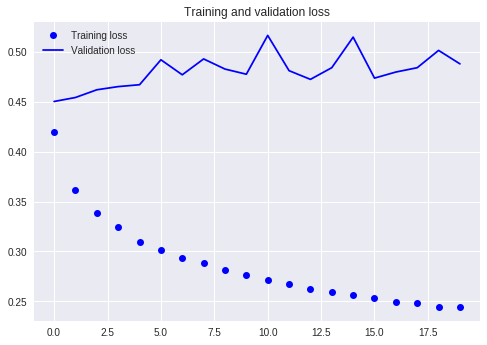

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


验证 MAE 停留在 0.4~0.5，使用小型卷积神经网络甚至无法击败基于常识的基准方法。同样，这是因为卷积神经网络在输入时间序列的所有位置寻找模式，它并不知道所看到某个模式的时间位置（距开始多长时间，距结束多长时间等）。对于这个具体的预测问题，对最新数据点的解释与对较早数据点的解释应该并不相同，所以卷积神经网络无法得到有意义的结果。卷积神经网络的这种限制对于 IMDB 数据来说并不是问题，因为对于与正面情绪或负面情绪相关联的关键词模式，无论出现在输入句子中的什么位置，它所包含的信息量是一样的。

要想结合卷积神经网络的速度和轻量与 RNN 的顺序敏感性，一种方法是在 RNN 前面使用一维卷积神经网络作为预处理步骤（见图 6-30）。对于那些非常长，以至于 RNN 无法处理的序列（比如包含上千个时间步的序列），这种方法尤其有用。卷积神经网络可以将长的输入序列转换为高级特征组成的更短序列（下采样）。然后，提取的特征组成的这些序列成为网络中 RNN 的输入。

这种方法在研究论文和实际应用中并不多见，可能是因为很多人并不知道。这种方法非常有效，应该被更多人使用。我们尝试将其应用于温度预测数据集。因为这种方法允许操作更长的序列，所以我们可以查看更早的数据（通过增大数据生成器的 lookback 参数）或查看分辨率更高的时间序列（通过减小生成器的 step 参数）。这里我们任意地将 step 减半，得到时间序列的长度变为之前的两倍，温度数据的采样频率变为每 30 分钟一个数据点。

In [0]:
# This was previously set to 6 (one point per hour).
# Now 3 (one point per 30 min).
# 之前设置为 6（每小时一个数据点），现在设置为 3（每 30 分钟一个数据点）
step = 3
lookback = 720  # Unchanged
delay = 144 # Unchanged

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

This is our model, starting with two `Conv1D` layers and following-up with a `GRU` layer:

In [0]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)
# 5*14+1=71*32=2272
# 32*(32+32)+32=2080*3=6240

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 123s 246ms/step - loss: 0.3413 - val_loss: 0.3003
Epoch 2/20
500/500 [==============

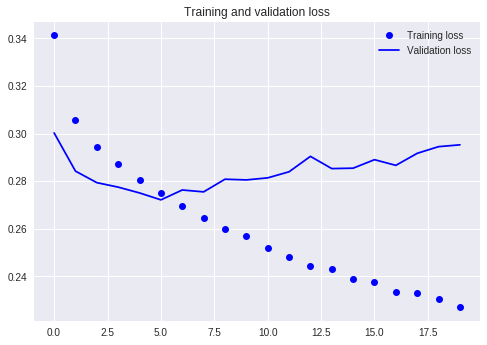

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

从验证损失来看，这种架构的效果不如只用正则化 GRU，但速度要快很多。它查看了两倍的数据量，在本例中可能不是非常有用，但对于其他数据集可能非常重要。

## Wrapping up

下面是你应该从本节中学到的要点。

* 二维卷积神经网络在二维空间中处理视觉模式时表现很好，与此相同，一维卷积神经网络在处理时间模式时表现也很好。对于某些问题，特别是自然语言处理任务，它可以替代 RNN，并且速度更快。
* 通常情况下，一维卷积神经网络的架构与计算机视觉领域的二维卷积神经网络很相似， 它将 Conv1D 层和 MaxPooling1D 层堆叠在一起，最后是一个全局池化运算或展平操作。
* 因为 RNN 在处理非常长的序列时计算代价很大，但一维卷积神经网络的计算代价很小， 所以在 RNN 之前使用一维卷积神经网络作为预处理步骤是一个好主意，这样可以使序列变短，并提取出有用的表示交给 RNN 来处理。

# 函数式编程

In [0]:
from keras.models import Model
from keras.layers import Conv1D,MaxPooling1D
from keras.layers import GlobalMaxPooling1D,Dense
from keras.optimizers import RMSprop
from keras.layers import Input

In [0]:
inputs = Input(shape =(None, float_data.shape[-1]))

In [0]:
x1 = Conv1D(32, 5, activation='relu')(inputs)
x2 = MaxPooling1D(3)(x1)
x3 = Conv1D(32, 5, activation='relu')(x2)
x4 = MaxPooling1D(3)(x3)
x5 = Conv1D(32,5,activation='relu')(x4)
x6 = GlobalMaxPooling1D()(x5)
output = Dense(1)(x6)

modelys = Model(inputs =inputs ,outputs=output)
modelys.compile(optimizer=RMSprop(), loss='mae')
modelys.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 14)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 32)                0         
__________

In [0]:
history = modelys.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 17s 33ms/step - loss: 0.4125 - val_loss: 0.4255
Epoch 2/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3585 - val_loss: 0.3960
Epoch 3/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3360 - val_loss: 0.4149
Epoch 4/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3213 - val_loss: 0.4308
Epoch 5/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3081 - val_loss: 0.4312
Epoch 6/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2992 - val_loss: 0.4427
Epoch 7/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2936 - val_loss: 0.4342
Epoch 8/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2848 - val_loss: 0.4329
Epoch 9/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2802 - val_loss: 0.4242
Epoch 10/20
500/500 [==============================] - 15s 30ms/step - loss: 0.275

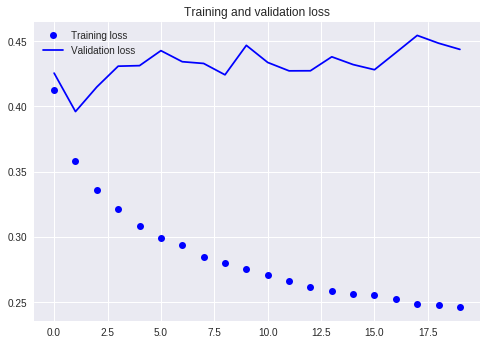

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 测试输入的shape

In [0]:
inputs2 = Input(shape =(240, float_data.shape[-1]))
x1 = Conv1D(32, 5, activation='relu')(inputs2)
x2 = MaxPooling1D(3)(x1)
x3 = Conv1D(32, 5, activation='relu')(x2)
x4 = MaxPooling1D(3)(x3)
x5 = Conv1D(32,5,activation='relu')(x4)
x6 = GlobalMaxPooling1D()(x5)
output2 = Dense(1)(x6)

modelys2 = Model(inputs =inputs2 ,outputs=output2)
modelys2.compile(optimizer=RMSprop(), loss='mae')
modelys2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 240, 14)           0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 236, 32)           2272      
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 78, 32)            0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 74, 32)            5152      
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 24, 32)            0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 20, 32)            5152      
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 32)                0         
__________

conv1d_41 (Conv1D) ： 输入为(None, 240, 14) ，输出为(None, 236 32)
236=240-5+1,32为卷积核的个数。参数数量:核的size看起来为5，但为了和输入匹配，核的真实size为(5,14)
则参数数量为[ 5*14+1（1为偏置） ]*32=2272.

maxPool:输出尺寸为236//3 =78

conv1d_42 (Conv1D) ： 输入为(None, 78, 32) ，输出为(None,74 32)
74=78-5+1,32为卷积核的个数。参数数量:核的size看起来为5，但为了和输入匹配，核的真实size为(5,32)
则参数数量为[ 5*32+1（1为偏置） ]*32=5152.

maxPool:输出尺寸为74/3 =24

conv1d_43 (Conv1D) ： 输入为(None, 24, 32) ，输出为(None,20 32)
20=24-5+1,32为卷积核的个数。参数数量:核的size看起来为5，但为了和输入匹配，核的真实size为(5,32)
则参数数量为[ 5*32+1（1为偏置） ]*32=5152.

GlobalMaxPooling1D的输出尺寸为32

Dense 的参数个数为32+1=33

In [0]:
history = modelys2.fit_generator(train_gen,
                              steps_per_epoch=200,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5
200/200 [==============================] - 11s 54ms/step - loss: 0.4504 - val_loss: 0.5030
Epoch 2/5
200/200 [==============================] - 11s 53ms/step - loss: 0.4011 - val_loss: 0.4047
Epoch 3/5
200/200 [==============================] - 11s 53ms/step - loss: 0.3809 - val_loss: 0.4157
Epoch 4/5
200/200 [==============================] - 11s 53ms/step - loss: 0.3654 - val_loss: 0.4104
Epoch 5/5
200/200 [==============================] - 11s 53ms/step - loss: 0.3523 - val_loss: 0.4207


In [0]:
value1= generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

In [0]:
value1

<generator object generator at 0x7f67691f3d58>

In [0]:
v1 = next(value1)

In [0]:
v1[0].shape

(128, 240, 14)

In [0]:
v1[1].shape

(128,)

# 测试3--输入维度不匹配

输入的维度为(128, 240, 14)，如果模型定义的输入为(128, 230, 14)，那么会报错

In [0]:
inputs3 = Input(shape =(230, float_data.shape[-1]))
x1 = Conv1D(32, 5, activation='relu')(inputs3)
x2 = MaxPooling1D(3)(x1)
x3 = Conv1D(32, 5, activation='relu')(x2)
x4 = MaxPooling1D(3)(x3)
x5 = Conv1D(32,5,activation='relu')(x4)
x6 = GlobalMaxPooling1D()(x5)
output3 = Dense(1)(x6)

modelys3 = Model(inputs =inputs3 ,outputs=output3)
modelys3.compile(optimizer=RMSprop(), loss='mae')
modelys3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 230, 14)           0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 226, 32)           2272      
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 75, 32)            0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 71, 32)            5152      
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 23, 32)            0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 19, 32)            5152      
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 32)                0         
__________

In [0]:
# 
history = modelys3.fit_generator(train_gen,
                              steps_per_epoch=200,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5


ValueError: ignored

# 二维卷积形状测试1

In [0]:
from keras.models import Model
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import GlobalMaxPooling2D,Dense
from keras.optimizers import RMSprop
from keras.layers import Input

## 输入少了一个维度

In [0]:
inputs5 = Input(shape =(240, 14))
# 少了一个维度
x1 = Conv2D(32, 5, activation='relu')(inputs5)
x2 = MaxPooling2D(3)(x1)
x3 = Conv2D(32, 5, activation='relu')(x2)
x4 = MaxPooling2D(3)(x3)
x5 = Conv2D(32,5,activation='relu')(x4)
x6 = GlobalMaxPooling2D()(x5)
output5 = Dense(1)(x6)

modelys5 = Model(inputs =inputs5 ,outputs=output5)
modelys5.compile(optimizer=RMSprop(), loss='mae')
modelys5.summary()

ValueError: ignored

## 输入维度正确

In [0]:
inputs5 = Input(shape =(64,64, 3))

x1 = Conv2D(32, 5, activation='relu')(inputs5)
x2 = MaxPooling2D(3)(x1)
x3 = Conv2D(32, 5, activation='relu')(x2)
x4 = MaxPooling2D(3)(x3)
x5 = Conv2D(32,5,activation='relu')(x4)
x6 = GlobalMaxPooling2D()(x5)
output5 = Dense(1)(x6)

modelys5 = Model(inputs =inputs5 ,outputs=output5)
modelys5.compile(optimizer=RMSprop(), loss='mae')
modelys5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 32)          25632     
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 32)                0         
__________

## 输入多了一个维度

In [0]:
inputs5 = Input(shape =(None,32,32,3))
# shape: 一个尺寸元组（整数），不包含批量大小
x1 = Conv2D(32, 5, activation='relu')(inputs5)
x2 = MaxPooling2D(3)(x1)
x3 = Conv2D(32, 5, activation='relu')(x2)
x4 = MaxPooling2D(3)(x3)
x5 = Conv2D(32,5,activation='relu')(x4)
x6 = GlobalMaxPooling2D()(x5)
output5 = Dense(1)(x6)

modelys5 = Model(inputs =inputs5 ,outputs=output5)
modelys5.compile(optimizer=RMSprop(), loss='mae')
modelys5.summary()

ValueError: ignored

## 输入指定batch

In [20]:
inputs5 = Input(batch_shape =(None,32,32,3))
# shape: 一个尺寸元组（整数），不包含批量大小
x1 = Conv2D(32, 3, activation='relu')(inputs5)
x2 = MaxPooling2D(2)(x1)
x3 = Conv2D(32, 3, activation='relu',padding='same')(x2)
x4 = MaxPooling2D(2)(x3)
x5 = Conv2D(32,3,activation='relu')(x4)
x6 = GlobalMaxPooling2D()(x5)
output5 = Dense(1)(x6)

modelys5 = Model(inputs =inputs5 ,outputs=output5)
modelys5.compile(optimizer=RMSprop(), loss='mae')
modelys5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 5, 32)          9248      
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 32)                0         
__________

# 二维卷积测试2-Seq

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam

In [23]:
model = Sequential()

# Conv layer 1 output shape (32, 28, 28)
model.add(Conv2D(
    batch_input_shape=(128, 1, 28, 28),
    # batch_input_shape=(None, 1, 28, 28),#不指定批次大小
    filters=32,
    kernel_size=5,
    strides=1,
    padding='same',     # Padding method
    data_format='channels_first',
))
model.add(Activation('relu'))

model.add(MaxPooling2D(
    pool_size=2,
    strides=2,
    padding='same',    # Padding method
    data_format='channels_first',
))

# Conv layer 2 output shape (64, 14, 14)
model.add(Conv2D(64, 5, strides=1, padding='same', data_format='channels_first'))
model.add(Activation('relu'))

# Pooling layer 2 (max pooling) output shape (64, 7, 7)
model.add(MaxPooling2D(2, 2, 'same', data_format='channels_first'))

# Fully connected layer 1 input shape (64 * 7 * 7) = (3136), output shape (1024)
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))

# Fully connected layer 2 to shape (10) for 10 classes
model.add(Dense(10))
model.add(Activation('softmax'))
adam = Adam(lr=1e-4)

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (128, 32, 28, 28)         832       
_________________________________________________________________
activation_1 (Activation)    (128, 32, 28, 28)         0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (128, 32, 14, 14)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (128, 64, 14, 14)         51264     
_________________________________________________________________
activation_2 (Activation)    (128, 64, 14, 14)         0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (128, 64, 7, 7)           0         
_________________________________________________________________
flatten_1 (Flatten)          (128, 3136)               0         
__________

# 一维卷积测试

## 输入多了一个维度

In [0]:
from keras import layers
model = Sequential()
# input_shape不能指定batch
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(128,240, 14)))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')

ValueError: ignored

## 可以指定batch

In [0]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        batch_input_shape=(128,240, 14)))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (128, 236, 32)            2272      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (128, 78, 32)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (128, 74, 32)             5152      
_________________________________________________________________
gru_3 (GRU)                  (128, 32)                 6240      
_________________________________________________________________
dense_6 (Dense)              (128, 1)                  33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


# 输入的维度

1、Sequential情况下
如果想要指定批次的大小，需要在第一层的输入形状中使用batch_input_shape
而不能使用input_shape，因为input_shape不能指定批次的大小，批次只能为None

input_shape和batch_input_shape。

input_shape 不包含批量大小，

batch_input_shape是全情投入的形状，包括批量大小。

2、函数式情况下

Input参数
shape: 一个尺寸元组（整数），不包含批量大小。A shape tuple (integer), not including the batch size. 例如，shape=(32,) 表明期望的输入是按批次的 32 维向量。

batch_shape: 一个尺寸元组（整数），包含批量大小。 例如，batch_shape=(10, 32) 表明期望的输入是 10 个 32 维向量。 batch_shape=(None, 32) 表明任意批次大小的 32 维向量。

# 可视化测试

将模型的结构保存为图像

In [0]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import os
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from keras.datasets import mnist
from keras.utils import plot_model

In [0]:
model = Sequential([
    Dense(512, activation="relu", input_shape=(784,),name='dense-one'),
    Dense(128 ,activation= "relu",name='dense-two'),
    Dense(10, activation="softmax",name='dense-three')
  ])
model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=["acc"])

In [0]:
plot_model(model, show_shapes=True, to_file='model1.png')